In [1]:
import sys
sys.path += ["/home/yousuf/workspace/dissertation/code/rPPG/python/core"]

In [2]:
from region_selection import BayesianSkinDetector
import helper

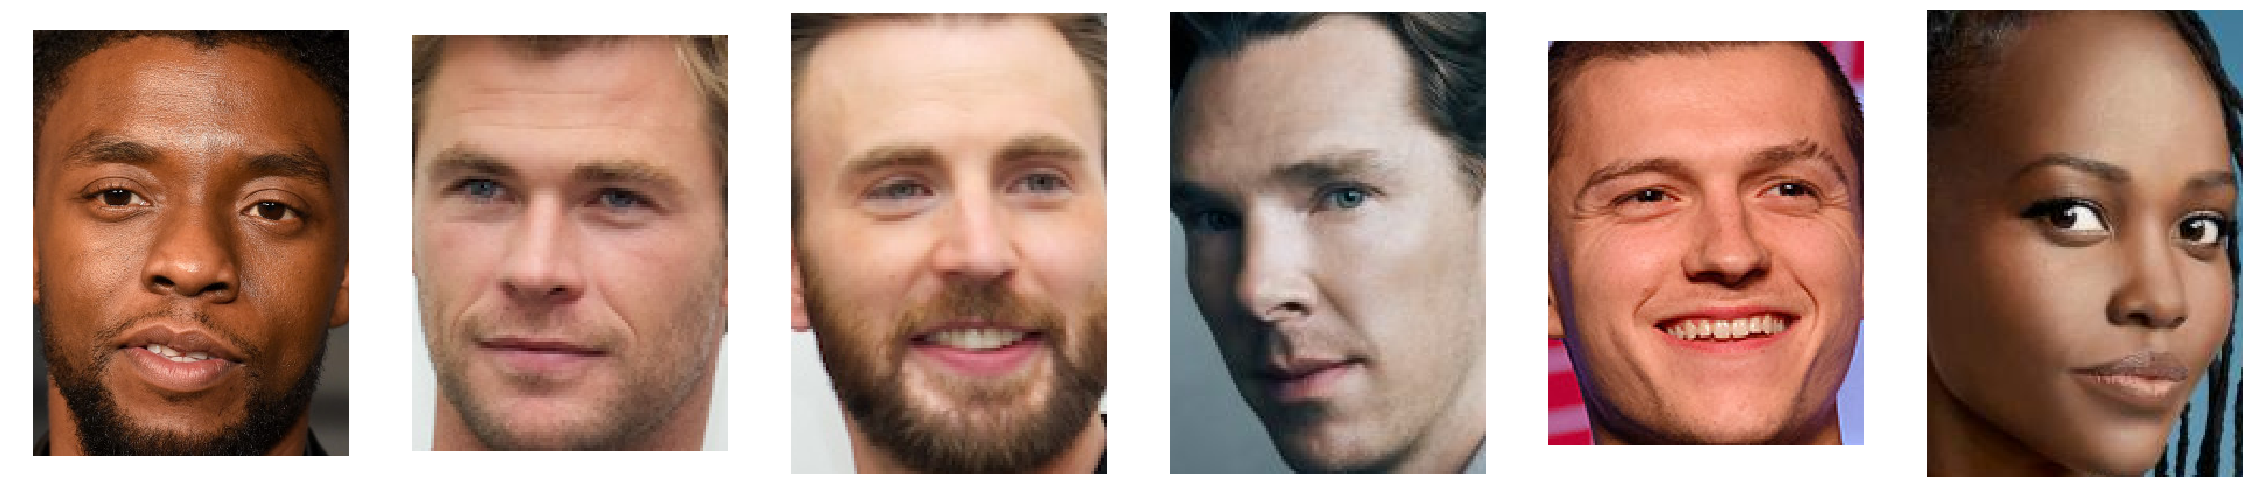

In [3]:
images = helper.get_cropped_test_images()
helper.show_images_plt(images)

Distance matrix: [[70.18331263 69.24225735 69.24225735 ... 73.49104583 72.52397293
  72.52397293]
 [70.18331263 68.90812959 69.24225735 ... 72.52397293 73.49104583
  73.49104583]
 [70.18331263 70.18331263 70.18331263 ... 72.52397293 72.52397293
  72.52397293]
 ...
 [71.44082831 70.48818895 70.48818895 ... 71.14514791 71.14514791
  70.18849551]
 [71.44082831 71.44082831 71.44082831 ... 71.14514791 71.14514791
  71.14514791]
 [71.44082831 71.44082831 70.48818895 ... 70.18849551 70.18849551
  70.18849551]]


/usr/lib/python3/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


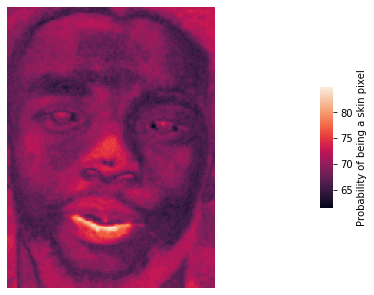

Std: 34.49134868291282
Cluster skin distance


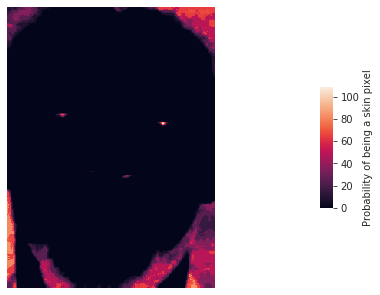

Skin probability


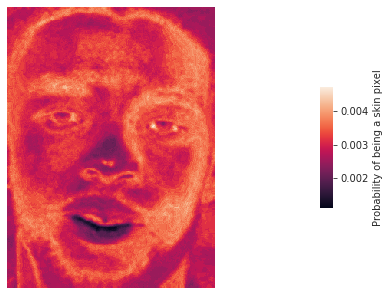

Not skin distance matrix


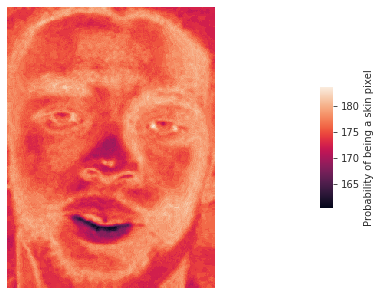

Not skin probability


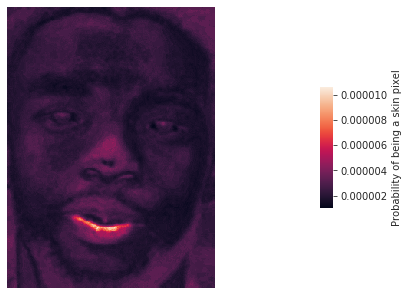

Weighted skin probability


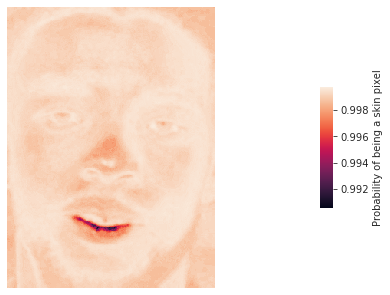

Prior heatmap


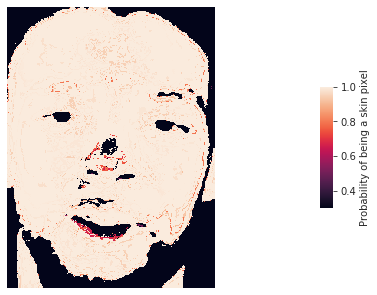

[[0.00378104 0.00382538 0.00382538 ... 0.00386064 0.00379407 0.00379407]
 [0.00378104 0.00384705 0.00382538 ... 0.00379407 0.00386064 0.00386064]
 [0.00378104 0.00378104 0.00378104 ... 0.00379407 0.00379407 0.00379407]
 ...
 [0.0037642  0.00377228 0.00377228 ... 0.00376346 0.00376346 0.00378087]
 [0.0037642  0.0037642  0.0037642  ... 0.00376346 0.00376346 0.00376346]
 [0.0037642  0.0037642  0.00377228 ... 0.00378087 0.00378087 0.00378087]]
Should be all ones
[[0.00147837 0.00144332 0.00144332 ... 0.00174504 0.00164012 0.00164012]
 [0.00147837 0.00143435 0.00144332 ... 0.00164012 0.00174504 0.00174504]
 [0.00147837 0.00147837 0.00147837 ... 0.00164012 0.00164012 0.00164012]
 ...
 [0.00155063 0.00149306 0.00149306 ... 0.00153078 0.00153078 0.0014786 ]
 [0.00155063 0.00155063 0.00155063 ... 0.00153078 0.00153078 0.00153078]
 [0.00155063 0.00155063 0.00149306 ... 0.0014786  0.0014786  0.0014786 ]]
Distance matrix: [[57.57792364 58.48124657 58.06266591 ... 58.97552104 58.97552104
  60.29704

/usr/lib/python3/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


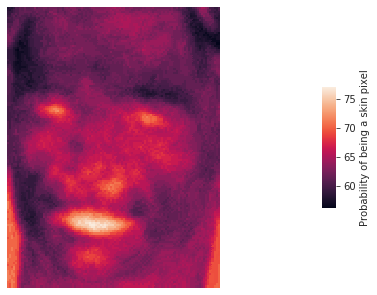

Std: 31.75808450220762
Cluster skin distance


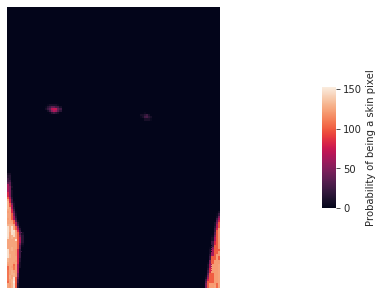

Skin probability


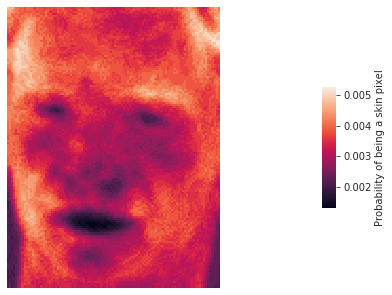

Not skin distance matrix


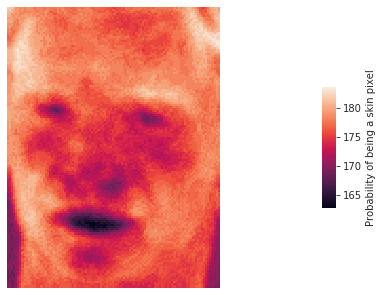

Not skin probability


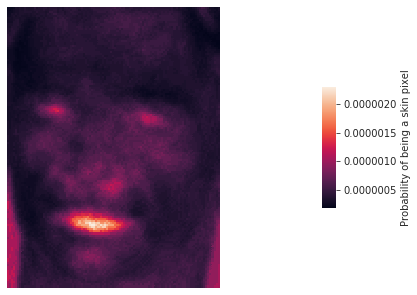

Weighted skin probability


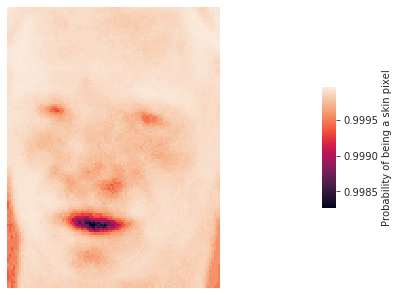

Prior heatmap


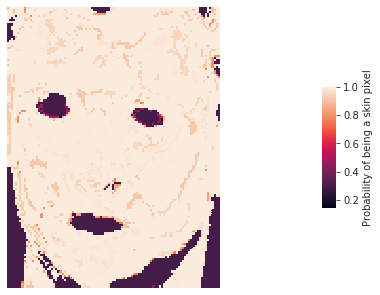

[[0.00490327 0.0046657  0.0047745  ... 0.00454012 0.00454012 0.00421993]
 [0.0046657  0.0047745  0.00454012 ... 0.00431583 0.00454012 0.00421993]
 [0.00454012 0.00454012 0.00454012 ... 0.00454012 0.00443781 0.00443781]
 ...
 [0.00264567 0.00265247 0.00260743 ... 0.00272287 0.00272287 0.00265247]
 [0.00265247 0.00272287 0.00260743 ... 0.00272287 0.00264567 0.00265247]
 [0.00265247 0.00272287 0.00260743 ... 0.00265247 0.00264567 0.00265247]]
Should be all ones
[[0.00405498 0.00461072 0.00472357 ... 0.00447993 0.00447993 0.00414326]
 [0.00461072 0.00472357 0.00447993 ... 0.00386525 0.00447993 0.00414326]
 [0.00447993 0.00447993 0.00447993 ... 0.00447993 0.00437291 0.00437291]
 ...
 [0.00099534 0.00099295 0.00101959 ... 0.00098076 0.00098076 0.00099295]
 [0.00099295 0.00098076 0.00101959 ... 0.00098076 0.00099534 0.00099295]
 [0.00099295 0.00098076 0.00101959 ... 0.00099295 0.00099534 0.00099295]]
Distance matrix: [[67.92944025 66.7681349  66.94657442 ... 65.96422363 66.60423298
  66.60423

/usr/lib/python3/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


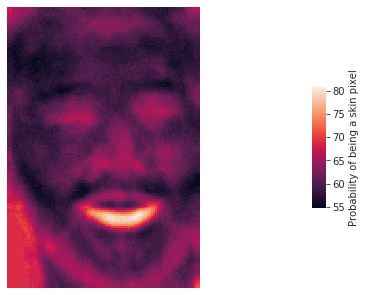

Std: 30.679789036483644
Cluster skin distance


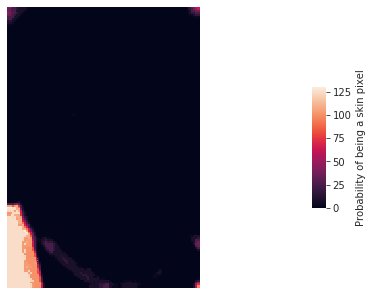

Skin probability


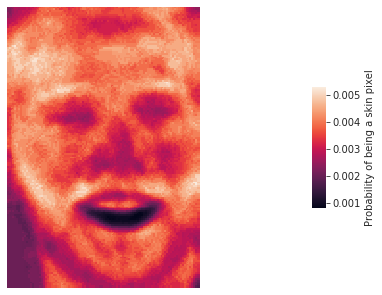

Not skin distance matrix


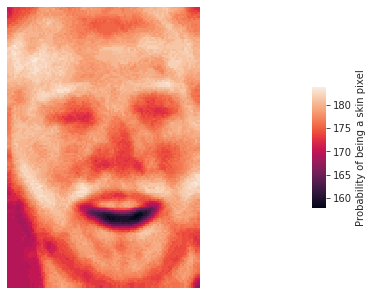

Not skin probability


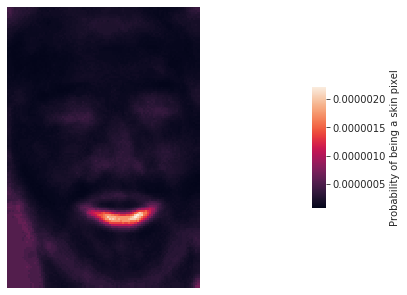

Weighted skin probability


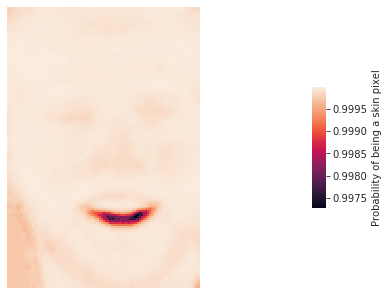

Prior heatmap


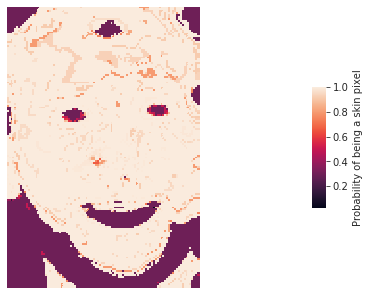

[[0.00244947 0.00260102 0.00257627 ... 0.00271881 0.0026242  0.0026242 ]
 [0.00244947 0.00244947 0.00255011 ... 0.00271881 0.00260102 0.0026242 ]
 [0.00244947 0.00244947 0.00255011 ... 0.00284318 0.0028762  0.00271881]
 ...
 [0.00231254 0.00231254 0.00231254 ... 0.00252185 0.00232065 0.0022625 ]
 [0.00231254 0.00231254 0.00231254 ... 0.00249421 0.00235764 0.0021977 ]
 [0.00231254 0.00231254 0.00231254 ... 0.00249421 0.00218731 0.00214749]]
Should be all ones
[[0.00081785 0.00084627 0.00084121 ... 0.00087192 0.00085112 0.00085112]
 [0.00081785 0.00081785 0.00083602 ... 0.00087192 0.00084627 0.00085112]
 [0.00081785 0.00081785 0.00083602 ... 0.00090117 0.00090922 0.00087192]
 ...
 [0.00080018 0.00080018 0.00080018 ... 0.00083061 0.00080088 0.00079728]
 [0.00080018 0.00080018 0.00080018 ... 0.00082553 0.00080475 0.00079915]
 [0.00080018 0.00080018 0.00080018 ... 0.00082553 0.00080041 0.00080988]]
Distance matrix: [[68.09984213 68.09984213 68.09984213 ... 69.59097002 69.72283161
  69.59097

/usr/lib/python3/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


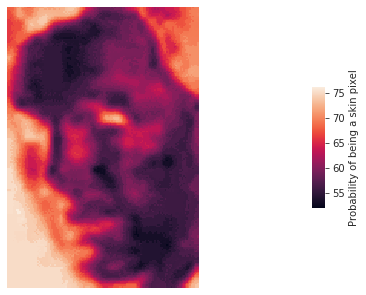

Std: 30.970898881794437
Cluster skin distance


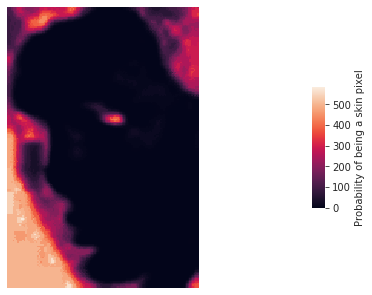

Skin probability


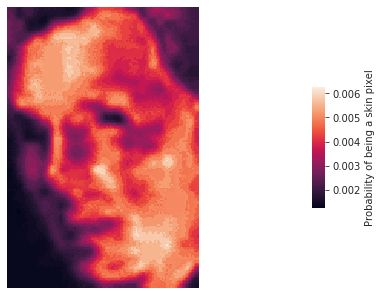

Not skin distance matrix


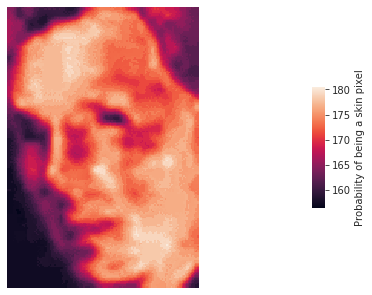

Not skin probability


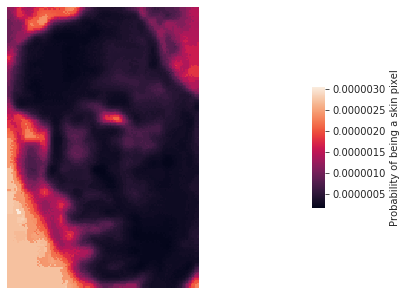

Weighted skin probability


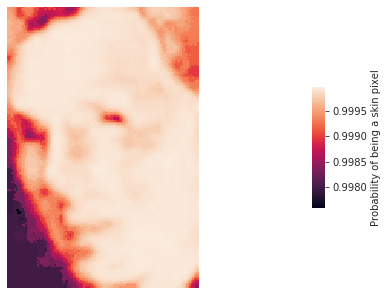

Prior heatmap


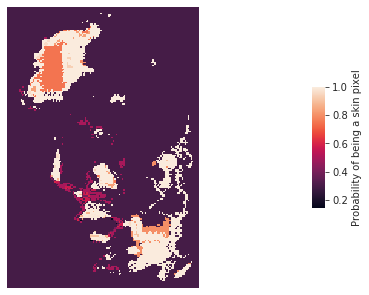

[[0.00282058 0.00282058 0.00282058 ... 0.00275908 0.00275709 0.00275908]
 [0.00282058 0.00282058 0.00282058 ... 0.00275908 0.00275709 0.00275709]
 [0.00289772 0.00289772 0.00282058 ... 0.00275709 0.00275709 0.00275709]
 ...
 [0.00336152 0.00336152 0.00336152 ... 0.00289636 0.00289636 0.00303942]
 [0.00336152 0.00336152 0.00336152 ... 0.00289636 0.00303942 0.00303942]
 [0.00336152 0.00336152 0.00336152 ... 0.00289636 0.00303942 0.00303942]]
Should be all ones
[[0.00105524 0.00105524 0.00105524 ... 0.00110534 0.0011118  0.00110534]
 [0.00105524 0.00105524 0.00105524 ... 0.00110534 0.0011118  0.0011118 ]
 [0.00104226 0.00104226 0.00105524 ... 0.0011118  0.0011118  0.0011118 ]
 ...
 [0.00180826 0.00180826 0.00180826 ... 0.00137093 0.00137093 0.00151874]
 [0.00180826 0.00180826 0.00180826 ... 0.00137093 0.00151874 0.00151874]
 [0.00180826 0.00180826 0.00180826 ... 0.00137093 0.00151874 0.00151874]]
Distance matrix: [[ 89.18348106  89.46261938  85.63521879 ... 119.61596622 122.82326338
  124

/usr/lib/python3/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


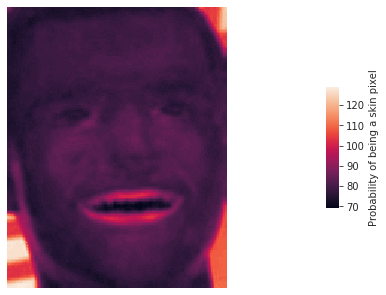

Std: 40.61463749701576
Cluster skin distance


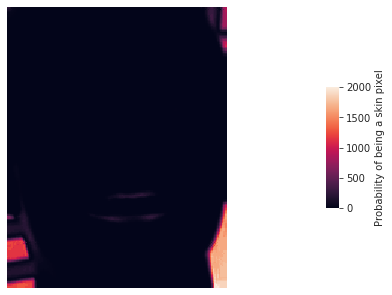

Skin probability


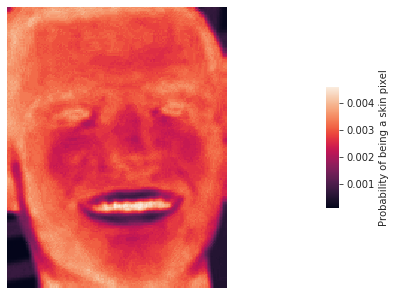

Not skin distance matrix


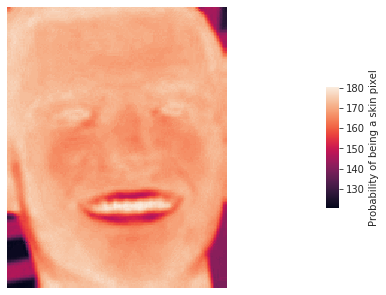

Not skin probability


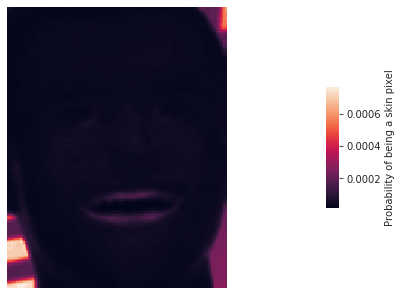

Weighted skin probability


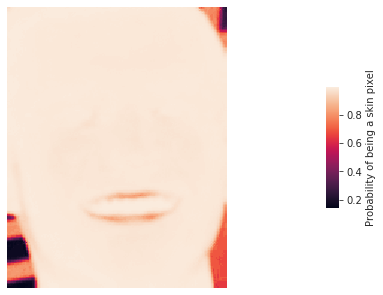

Prior heatmap


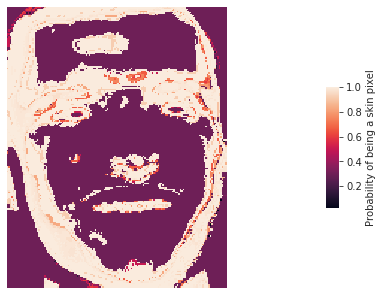

[[0.04123391 0.0425144  0.02816064 ... 0.64490791 0.73235088 0.77229944]
 [0.0382877  0.03451566 0.02549967 ... 0.66812398 0.73235088 0.77229944]
 [0.02816064 0.02549967 0.021042   ... 0.66812398 0.73235088 0.77229944]
 ...
 [0.73235088 0.71834434 0.75282156 ... 0.35519635 0.35519635 0.35519635]
 [0.81435919 0.81435919 0.81435919 ... 0.35519635 0.35519635 0.35519635]
 [0.84539671 0.84539671 0.84539671 ... 0.35519635 0.35519635 0.35519635]]
Should be all ones
[[0.02812965 0.02903602 0.01883872 ... 0.45114674 0.51234316 0.54029618]
 [0.02604233 0.02336531 0.01693451 ... 0.46739548 0.51234316 0.54029618]
 [0.01883872 0.01693451 0.01372601 ... 0.46739548 0.51234316 0.54029618]
 ...
 [0.51234316 0.50254162 0.52666749 ... 0.24833024 0.24833024 0.24833024]
 [0.5697215  0.5697215  0.5697215  ... 0.24833024 0.24833024 0.24833024]
 [0.59143074 0.59143074 0.59143074 ... 0.24833024 0.24833024 0.24833024]]
Distance matrix: [[68.04055593 68.04055593 68.04055593 ... 95.21775055 95.48813949
  95.48813

/usr/lib/python3/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


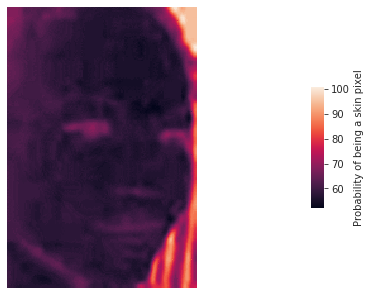

Std: 30.212500534001673
Cluster skin distance


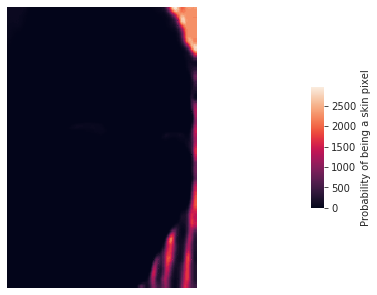

Skin probability


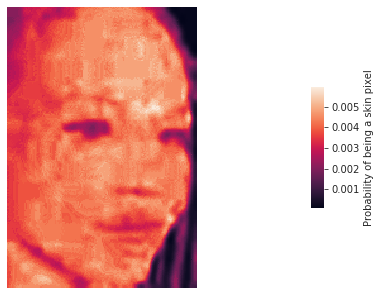

Not skin distance matrix


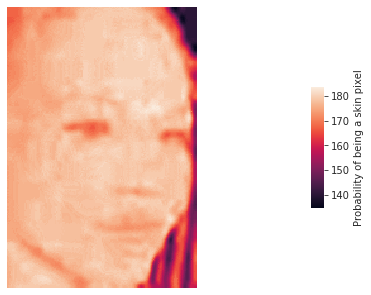

Not skin probability


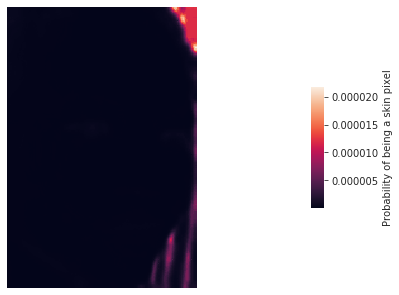

Weighted skin probability


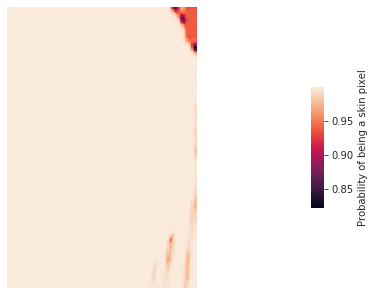

Prior heatmap


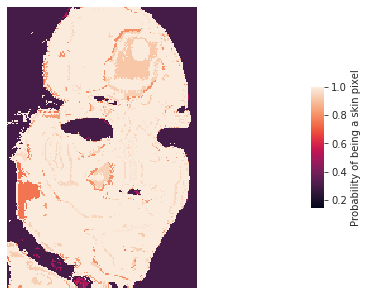

[[0.00233033 0.00233033 0.00233033 ... 0.06172881 0.06510624 0.06510624]
 [0.00233033 0.00233033 0.00233033 ... 0.06172881 0.06510624 0.06510624]
 [0.00233033 0.00233033 0.00233033 ... 0.06172881 0.06172881 0.06172881]
 ...
 [0.00375195 0.00375195 0.00388385 ... 0.00230848 0.00218162 0.00218162]
 [0.00375195 0.00397552 0.00411237 ... 0.00231796 0.00230113 0.00230113]
 [0.00375195 0.00388385 0.00411237 ... 0.00231796 0.00247662 0.00247662]]
Should be all ones
[[0.0007945  0.0007945  0.0007945  ... 0.04313172 0.04549783 0.04549783]
 [0.0007945  0.0007945  0.0007945  ... 0.04313172 0.04549783 0.04549783]
 [0.0007945  0.0007945  0.0007945  ... 0.04313172 0.04313172 0.04313172]
 ...
 [0.00114412 0.00114412 0.00289215 ... 0.00116603 0.00103662 0.00103662]
 [0.00114412 0.00393703 0.00407785 ... 0.00117501 0.00115902 0.00115902]
 [0.00114412 0.00289215 0.00407785 ... 0.00117501 0.00131798 0.00131798]]


In [4]:
heatmaps = [BayesianSkinDetector(skin_std=40, non_skin_std=150).detect(i) for i in images]

Skin posterior


/usr/lib/python3/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


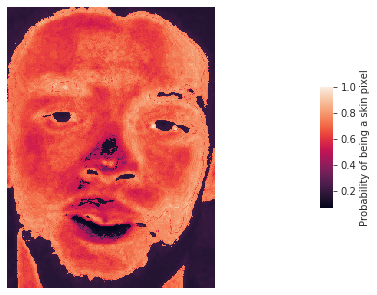

Not skin posterior


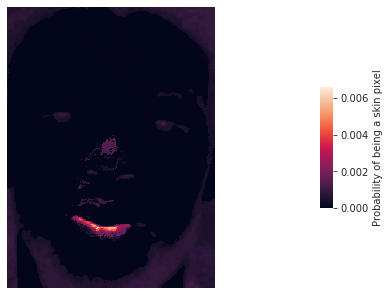

Mask above mean


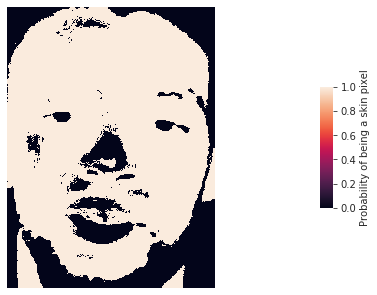

Top 70% of values


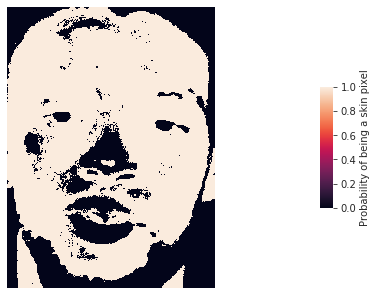

Top 70% of values


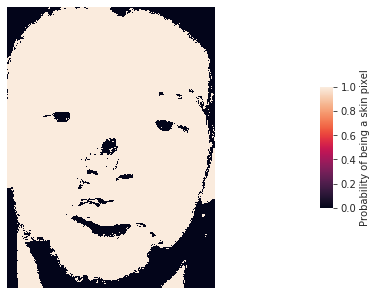

Mask above 0.5


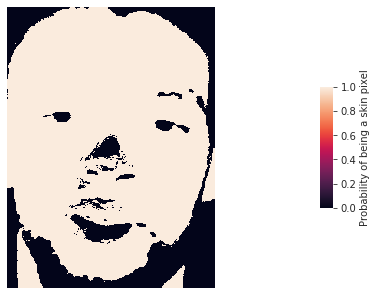

Skin posterior


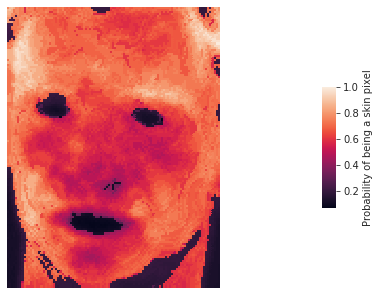

Not skin posterior


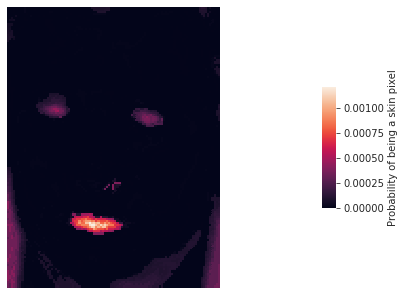

Mask above mean


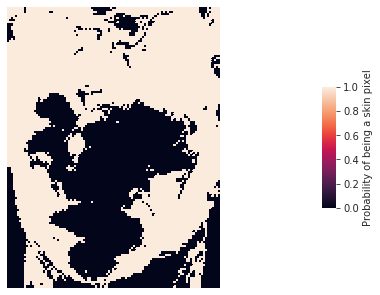

Top 70% of values


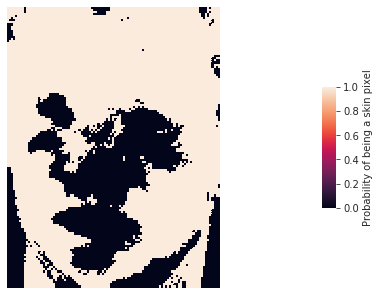

Top 70% of values


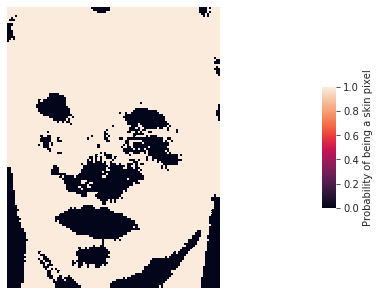

Mask above 0.5


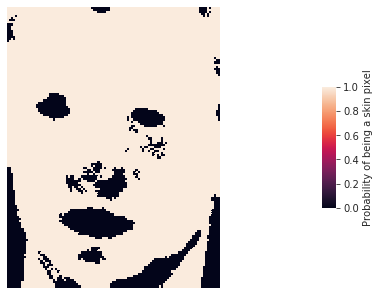

Skin posterior


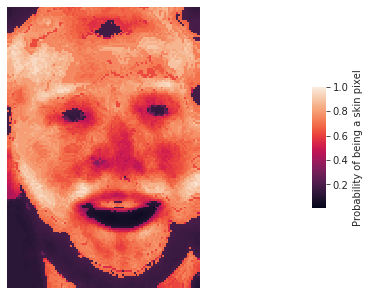

Not skin posterior


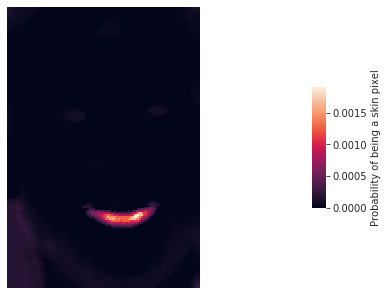

Mask above mean


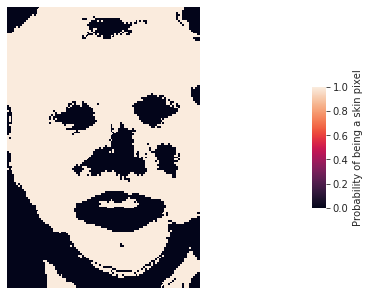

Top 70% of values


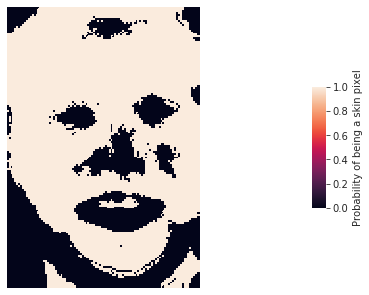

Top 70% of values


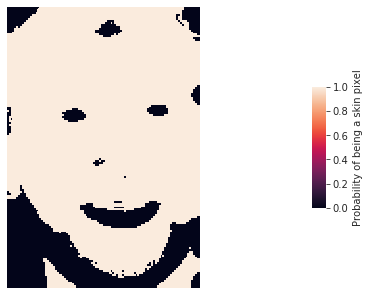

Mask above 0.5


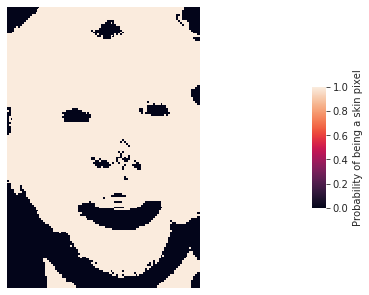

Skin posterior


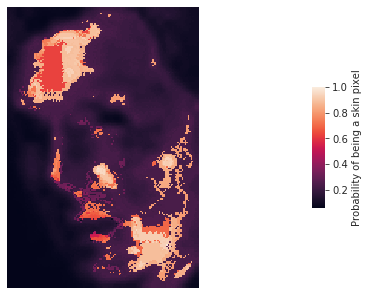

Not skin posterior


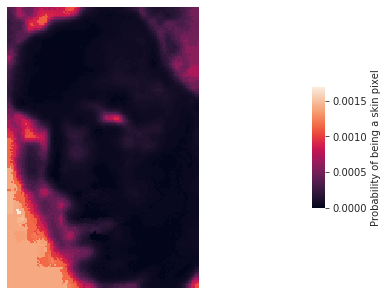

Mask above mean


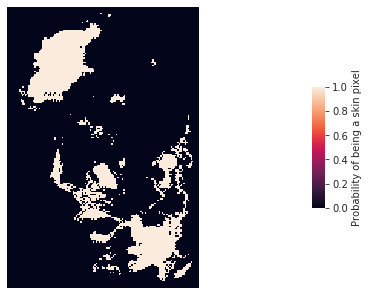

Top 70% of values


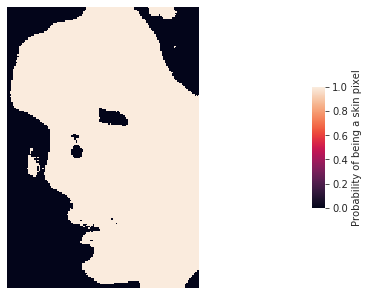

Top 70% of values


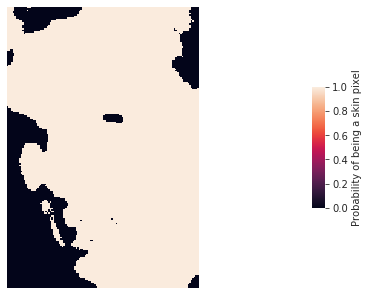

Mask above 0.5


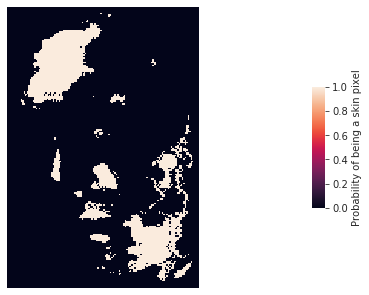

Skin posterior


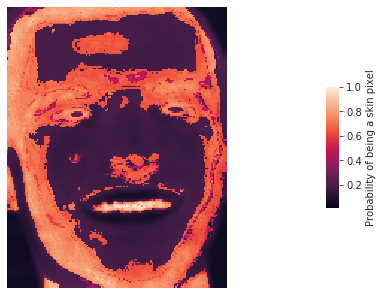

Not skin posterior


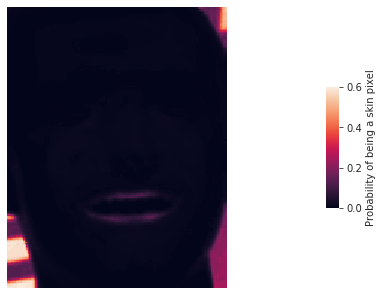

Mask above mean


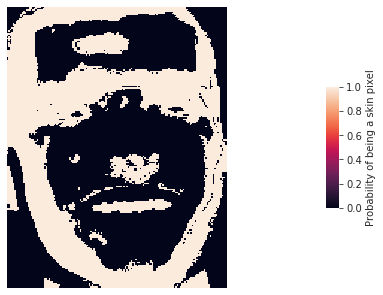

Top 70% of values


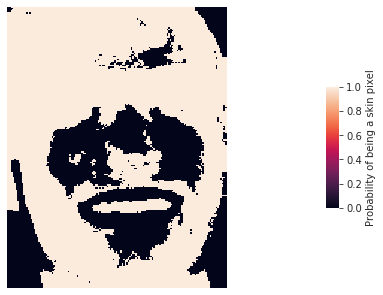

Top 70% of values


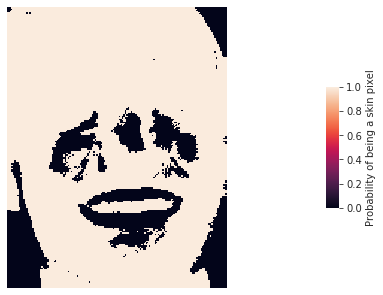

Mask above 0.5


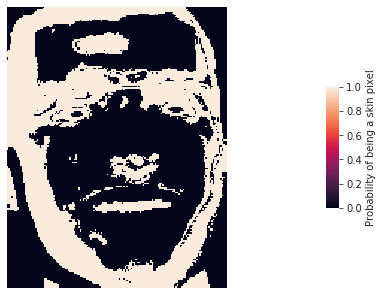

Skin posterior


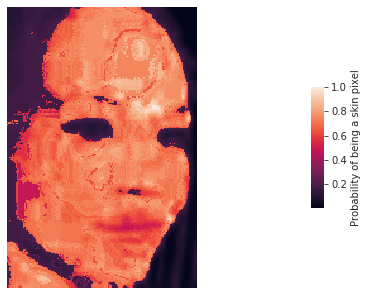

Not skin posterior


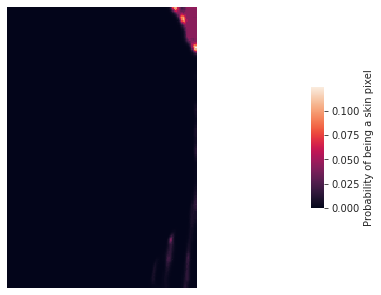

Mask above mean


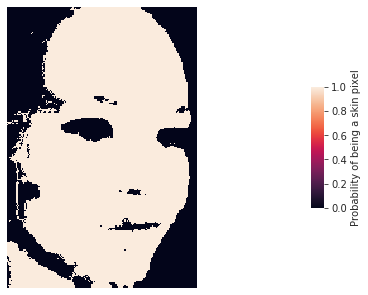

Top 70% of values


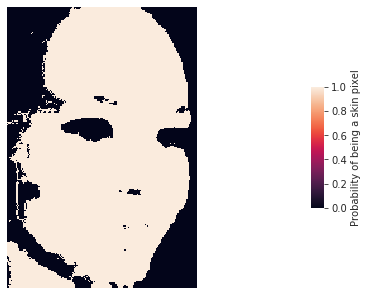

Top 70% of values


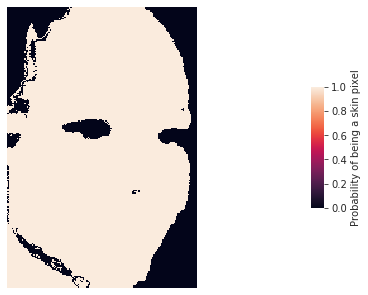

Mask above 0.5


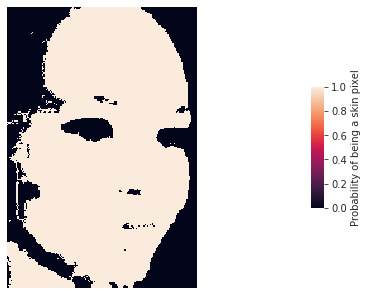

In [5]:
import numpy as np
for t in heatmaps:
    x,y,z,a = t
#     print(x)
#     print(y)
    print("Skin posterior")
    helper.display_heatmap([x])
    print("Not skin posterior")
    helper.display_heatmap([y])
#     print(z)
    w,h = z.shape
#     print(np.sum(z)/(w*h))
    print("Mask above mean")
    helper.display_heatmap([x>np.mean(x)])
    print("Top 70% of values")
    helper.display_heatmap([x>np.percentile(x, 30)])
    print("Top 70% of values")
    helper.display_heatmap([x>np.percentile(x, 20)])
    print("Mask above 0.5")
    helper.display_heatmap([a])